# Import packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys
import time
import ROOT
import pandas as pd
from root_pandas import read_root
from matplotlib.ticker import NullFormatter
import matplotlib as mpl
mpl.rcParams.update({'font.size': 16})
mpl.rcParams.update({'xtick.labelsize': 16}) 
mpl.rcParams.update({'ytick.labelsize': 16}) 


Welcome to JupyROOT 6.09/01


# Defines how to get dataframe from ROOT TTree

In [2]:
def getData(inputFiles):
   
    cols = ['cluster_pt','cluster_eta','cluster_phi','cluster_e_cross','cluster_e','cluster_ncell','cluster_iso_tpc_04','cluster_iso_its_04','cluster_NN1','cluster_NN2','cluster_Lambda']
    dataframes = []
    for inputFilename in inputFiles:
        start = time.time()
        df = read_root(inputFilename, columns=cols,flatten=cols)
        dataframes.append(df)
        end = time.time()
        print 'Processed', inputFilename, 'in',  end-start, 'seconds'
    return pd.concat([x for x in dataframes])

# Gets dataframes from dataset(s)

In [55]:
# NTuples found in /project/projectdirs/alice/NTuples
mcFiles = ["16c3b_small.root"]
dataFiles = ["13def_small.root"]#,"13e_small.root",'13e_small.root']
mcHists = getData(mcFiles)
dataHists = getData(dataFiles)



# Define cuts

In [57]:
def applyCuts(data):
    data.eval('ecrossOvere = cluster_e_cross/cluster_e', inplace=True)
    print 'Before cuts' , data.shape
    data = data.query('cluster_pt>8.0')
    print 'Ater pt > 8 GeV cut ' , data.shape
    data = data.query('ecrossOvere>0.03')
    print 'After ecross/e > 0.03 cut' , data.shape
    data = data.query('cluster_NN2<1.0 and cluster_NN2>0')
    print 'After NN2 within (0.1) ', data.shape
    data = data.query('cluster_NN1<1.0 and cluster_NN1>0')
    print 'After NN2 within (0.1)', data.shape
    data = data.query('cluster_iso_tpc_04<100')
    print 'After iso < 100 cut ', data.shape
    data = data.query('cluster_ncell>2')
    print 'After ncell > 2 cut ', data.shape
    data = data.query('cluster_Lambda<2.0')
    print 'After lambda < 2.0 ' , data.shape
    #print data.head(5)
    #print data.shape
    #print data[0].count()
    return data

# Apply cuts

In [58]:
dataHists = applyCuts(dataHists)
mcHists = applyCuts(mcHists)

In [62]:

def plotcorr(histo,label,figname):
    x = histo['cluster_NN1']
    y = histo['cluster_Lambda']
    nullfmt = NullFormatter()         # no labels
    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    bottom_h = left_h = left + width + 0.04
    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom_h, width, 0.2]
    rect_histy = [left_h, bottom, 0.2, height]
    fig = plt.figure(1, figsize=(8, 8))
    axScatter = plt.axes(rect_scatter)
    axHistx = plt.axes(rect_histx)
    axHisty = plt.axes(rect_histy)
    axHistx.xaxis.set_major_formatter(nullfmt) #no labels
    axHisty.yaxis.set_major_formatter(nullfmt)
    hb = axScatter.hexbin(x, y, cmap='viridis') #gridsize=60
    plt.text(0.72, 0.90,label, horizontalalignment='center',  verticalalignment='center', transform=axScatter.transAxes, bbox=dict(facecolor='white', alpha=0.75))
    binwidth = 0.25
    xymax = np.max([np.max(np.fabs(x)), np.max(np.fabs(y))])
    lim = (int(xymax/binwidth) + 1) * binwidth
    axScatter.set_xlim((0.0, 1.0))
    axScatter.set_ylim((0.0, 1.0))
    axScatter.set_xlabel('NN output')
    axScatter.set_ylabel('Lambda')
    bins = np.arange(-lim, lim + binwidth, binwidth)
    axHistx.hist(x,50)
    axHisty.hist(y,100, orientation='horizontal')
    axHistx.set_xlim(axScatter.get_xlim())
    axHisty.set_ylim(axScatter.get_ylim())
    plt.show()
    fig.savefig(figname+'.png', dpi=fig.dpi)

In [64]:
def cutptrange(data, ptmin, ptmax):
    full = data
    iso = data.query('cluster_iso_tpc_04<5')
    noniso = data.query('cluster_iso_tpc_04>10')
    full = full.query('cluster_pt>%f and cluster_pt<%f' %(ptmin,ptmax))
    iso = iso.query('cluster_pt>%f and cluster_pt<%f' %(ptmin,ptmax))
    noniso = noniso.query('cluster_pt>%f and cluster_pt<%f' %(ptmin,ptmax))
    return full, iso, noniso  

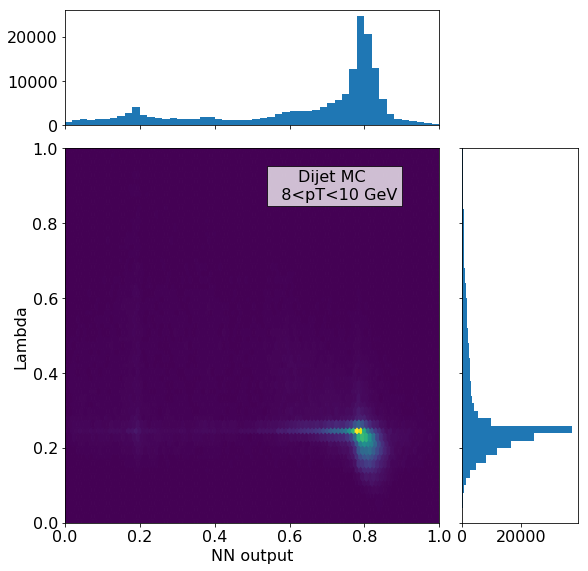

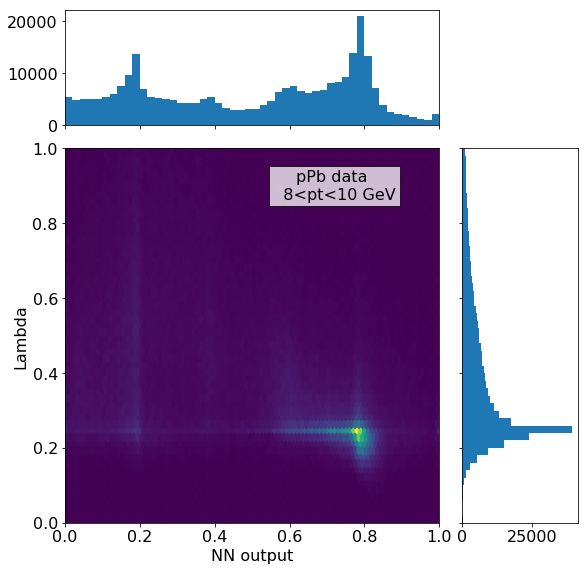

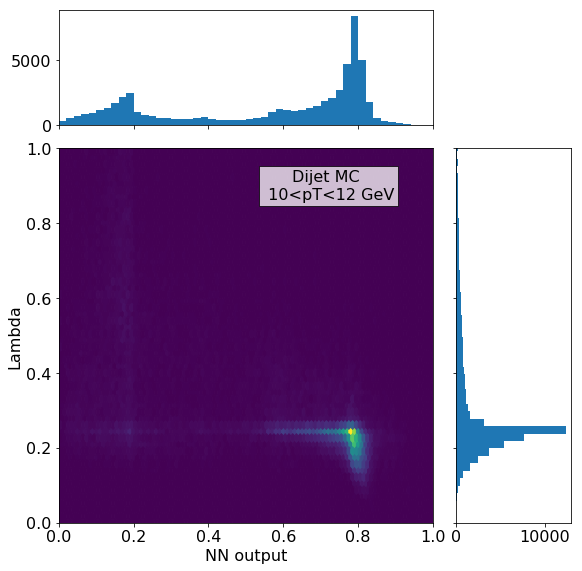

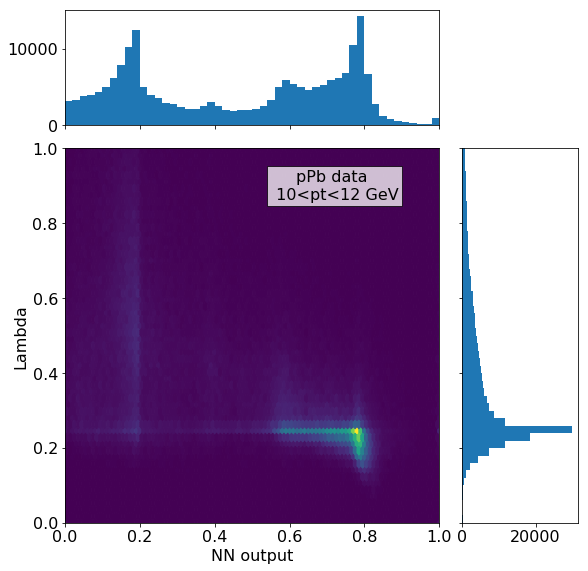

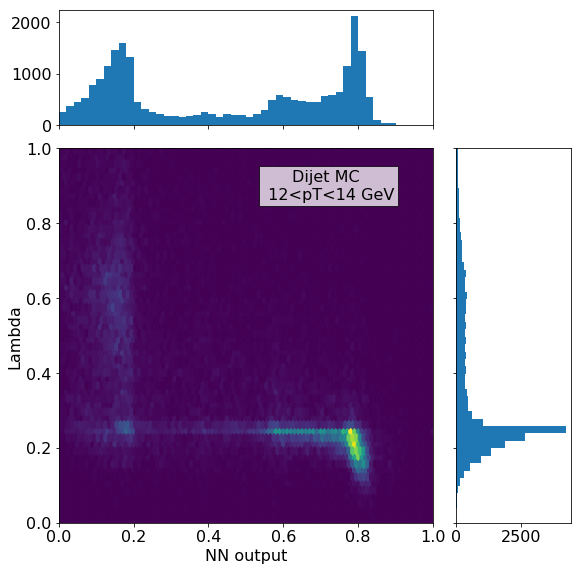

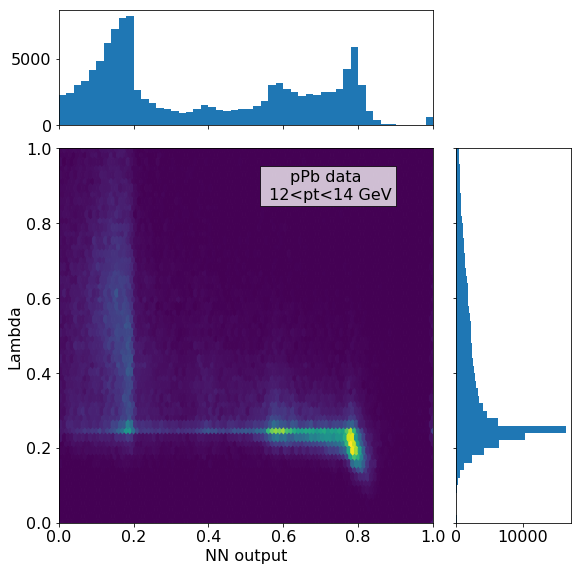

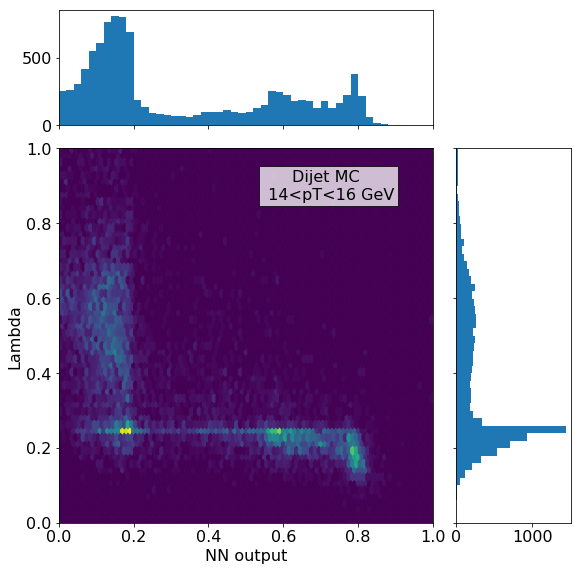

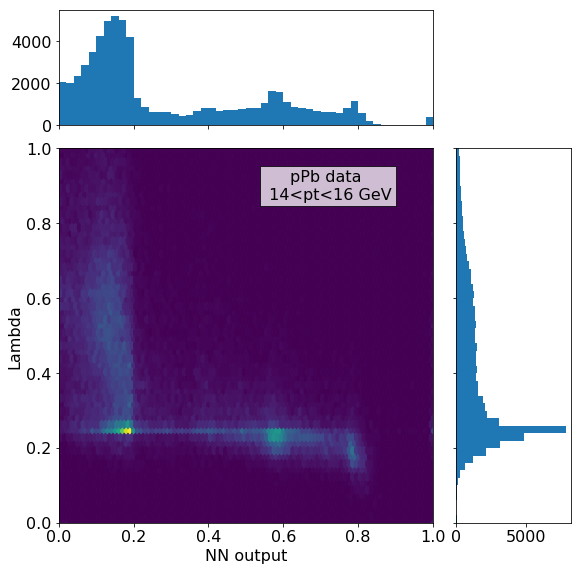

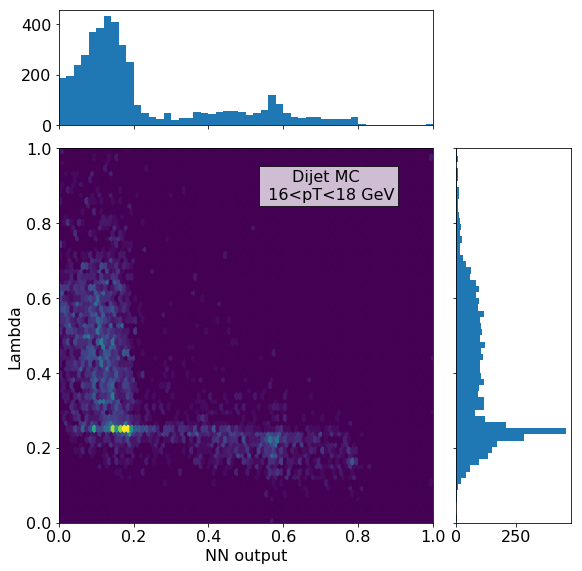

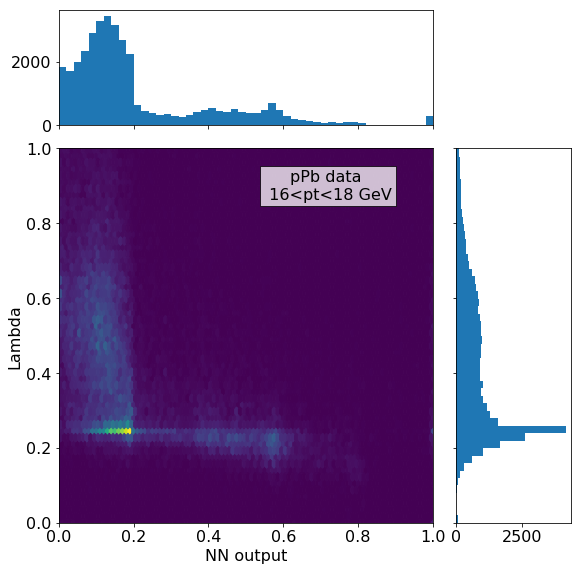

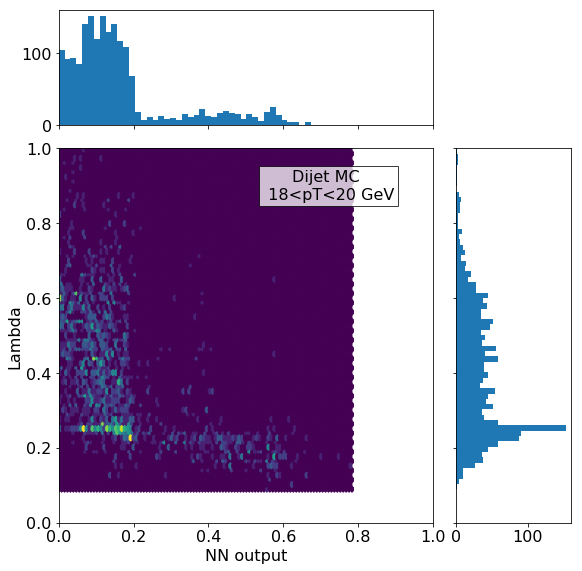

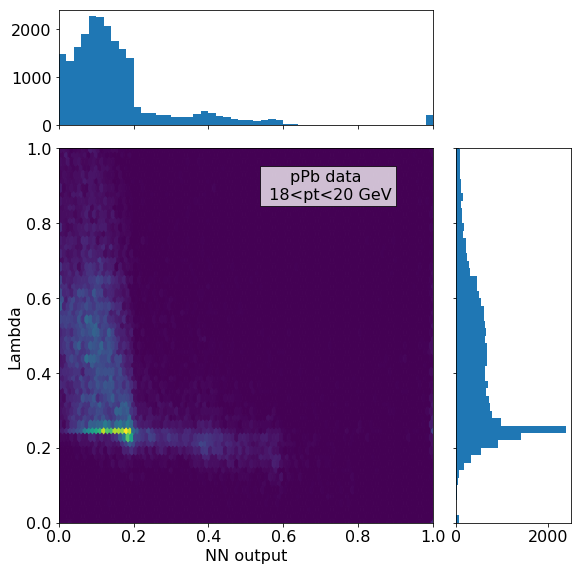

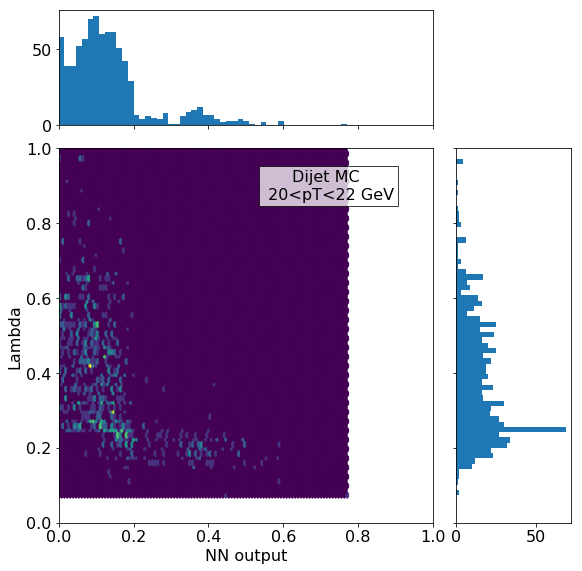

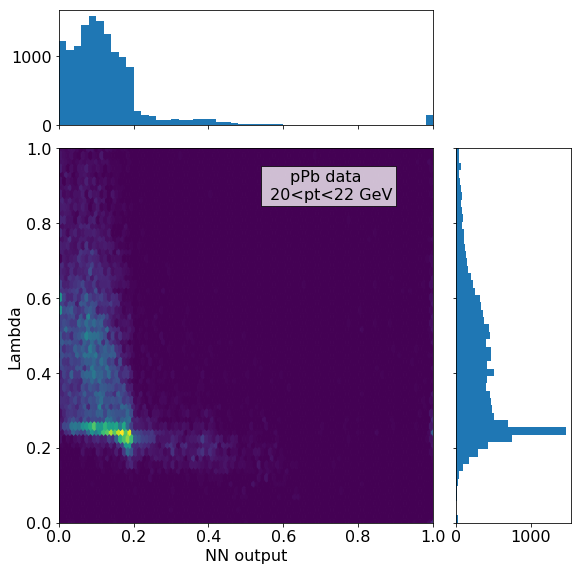

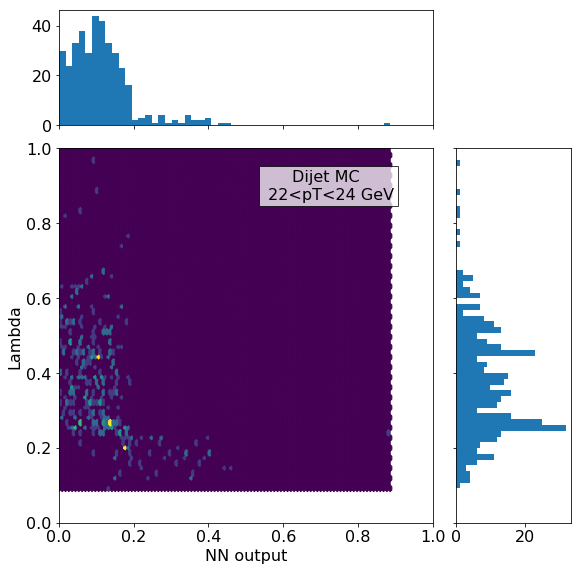

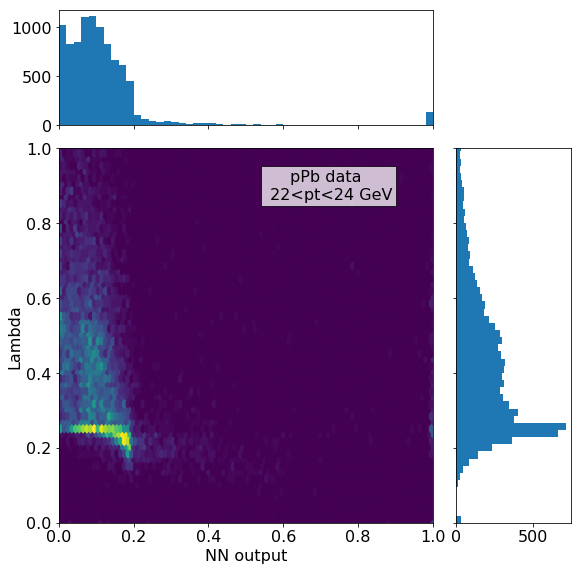

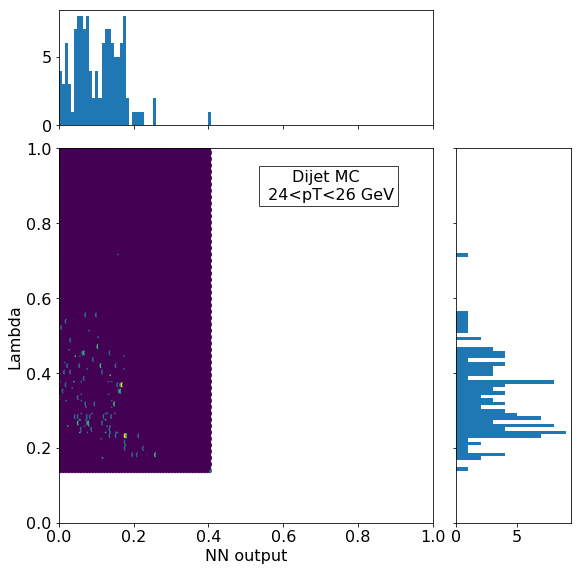

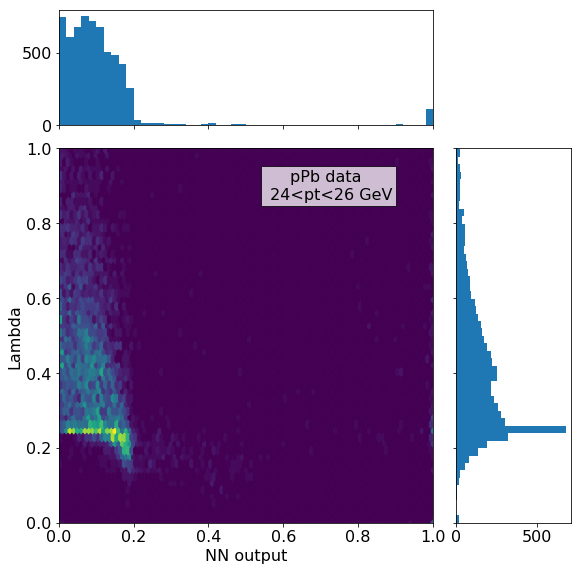

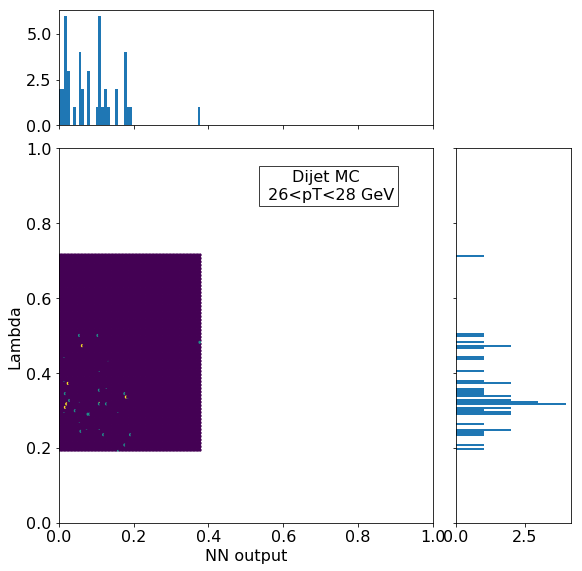

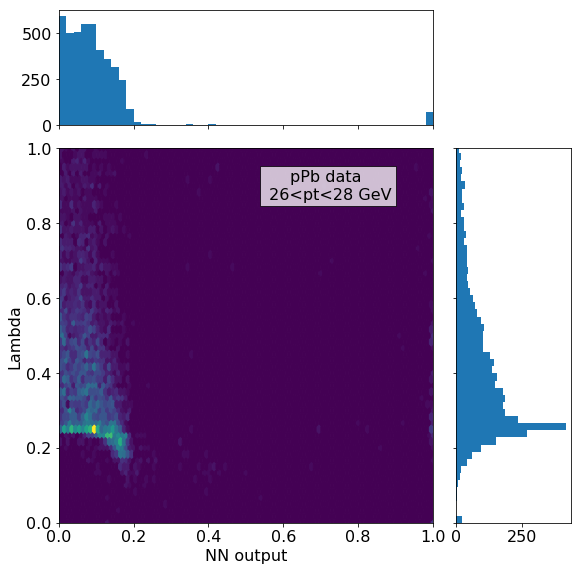

In [66]:
binedges = [8.0, 10.0,12.0,14.0,16.0,18.0,20.0,22.0,24.0,26.0,28.0]

#full, iso, noniso = cutptrange(dataHists, 8.0, 12.0)
#plotcorr(full,'pPb data \n 12 <pt < 14 GeV','all')

for ipt in range(len(binedges)-1):
    ptmin = binedges[ipt]
    ptmax = binedges[ipt+1]
    full, iso, noniso = cutptrange(mcHists, ptmin, ptmax)
    plotcorr(full,'Dijet MC \n %2.0f<pT<%2.0f GeV' %(ptmin,ptmax),'all_MC_%2.0f_%2.0f' %(ptmin,ptmax))
    full, iso, noniso = cutptrange(dataHists, ptmin, ptmax)
    plotcorr(full,'pPb data \n %2.0f<pt<%2.0f GeV' %(ptmin,ptmax),'all_Data%2.0f_%2.0f' %(ptmin,ptmax))
